In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print(tf.__version__)

2.3.2


In [3]:
import pathlib
data_dir = pathlib.Path('images')
print(data_dir)

images


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1546


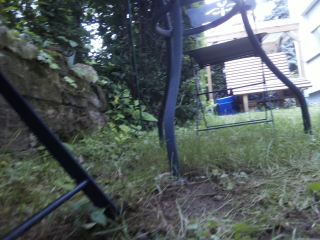

In [5]:
hindernis = list(data_dir.glob('hindernis/*'))
PIL.Image.open(str(hindernis[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1546 files belonging to 2 classes.
Using 1237 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1546 files belonging to 2 classes.
Using 309 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['hindernis', 'kein_hindernis']


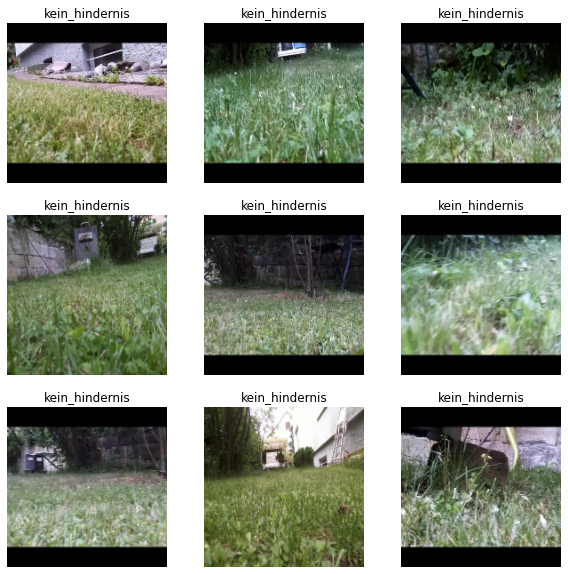

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

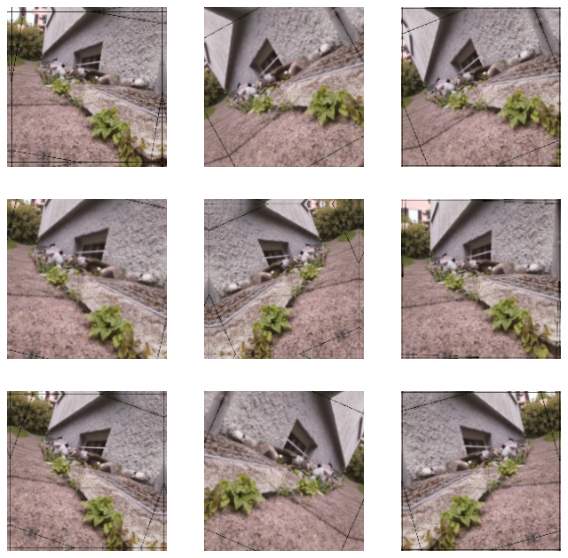

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
39/39 [==============================] - 10s 264ms/step - loss: 0.5379 - accuracy: 0.7712 - val_loss: 0.4720 - val_accuracy: 0.8414
Epoch 2/15
39/39 [==============================] - 4s 98ms/step - loss: 0.4015 - accuracy: 0.8238 - val_loss: 0.3983 - val_accuracy: 0.8414
Epoch 3/15
39/39 [==============================] - 4s 98ms/step - loss: 0.3172 - accuracy: 0.8618 - val_loss: 0.2669 - val_accuracy: 0.8770
Epoch 4/15
39/39 [==============================] - 4s 98ms/step - loss: 0.3227 - accuracy: 0.8698 - val_loss: 0.2698 - val_accuracy: 0.8867
Epoch 5/15
39/39 [==============================] - 4s 98ms/step - loss: 0.2883 - accuracy: 0.8739 - val_loss: 0.2732 - val_accuracy: 0.8738
Epoch 6/15
39/39 [==============================] - 4s 98ms/step - loss: 0.3126 - accuracy: 0.8698 - val_loss: 0.3753 - val_accuracy: 0.8350
Epoch 7/15
39/39 [==============================] - 4s 98ms/step - loss: 0.3081 - accuracy: 0.8666 - val_loss: 0.3807 - val_accuracy: 0.8317
Epoch 8/15


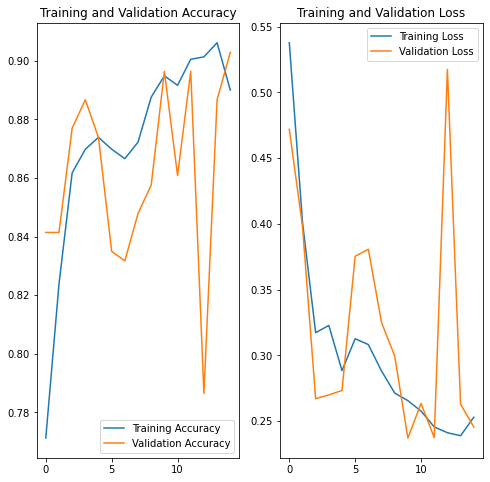

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.save('saved_model/mower_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/mower_model/assets


In [22]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/mower_model') # path to the SavedModel directory
tflite_model = converter.convert()

In [23]:
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)